# Cifar10 上的 ReNet18 Sigmoid 线性化

本文主要介绍在 cifar10 的试验 resnet18 的性能。

导入一些必要包：

In [1]:
import torch
from torch import nn, fx, optim
from torchvision.models import resnet18, ResNet18_Weights
from torch_book.data.simple_vision import load_data_cifar10
from torch_book.tools import train, try_all_gpus, evaluate_accuracy

torch.cuda.empty_cache() # 清空 GPU 缓存

def create_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.conv1 = nn.Conv2d(model.conv1.in_channels, 
                            model.conv1.out_channels, 
                            3, 1, 1)
    model.maxpool = nn.Identity() #nn.Conv2d(64, 64, 1, 1, 1)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

In [2]:
batch_size = 32
train_iter, test_iter = load_data_cifar10(batch_size=batch_size)
model = create_model()
# 加载模型参数
state_dict = torch.load("models/resnet18_cifar10_batch_size_64.h5")
model.load_state_dict(state_dict)

Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

In [3]:
relu_valid_acc = evaluate_accuracy(model, test_iter)
relu_valid_acc

0.9245

## 模块变换

利用 FX 替换全部 {class}`~torch.nn.ReLU` 为 {func}`torch.sigmoid`。

In [4]:
def replace(model):
    mod = fx.symbolic_trace(model)
    # 遍历 Graph 中全部节点
    for node in mod.graph.nodes:
        # 如果匹配目标
        if node.op == "call_module":
            if "relu" in node.target:
                # 设置插入点，添加新节点，用新节点替换所有 `node` 的用法
                with mod.graph.inserting_after(node):
                    new_node = mod.graph.call_function(torch.sigmoid, node.args, node.kwargs)
                    node.replace_all_uses_with(new_node)
                # 移除 graph 中旧的节点
                mod.graph.erase_node(node)
    mod.graph.lint()
    # 不用忘记 recompile！
    new_code = mod.recompile()
    return mod

In [5]:
mod = replace(model)

In [6]:
valid_acc = evaluate_accuracy(mod, test_iter)
valid_acc

0.1

微调：

In [7]:
def fine_tune(mod, num_epochs,
              train_iter, test_iter,
              devices=try_all_gpus(),
              lr=0.0000142857,
              lr_period=4,
              lr_decay=0.0857142,
              weight_decay=0.00857142,
              momentum=0.857142):
    optimizer = optim.SGD(mod.parameters(),
                          lr=lr,
                          momentum=momentum, 
                          weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                          step_size=lr_period, 
                                          gamma=lr_decay)
    train(mod, train_iter, test_iter,
          num_epochs, devices,
          optimizer, scheduler)
    return mod

train loss 0.199, train acc 0.932, valid acc 0.840
641.9 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


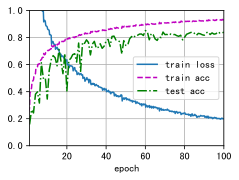

In [8]:
mod = replace(model)
mod = fine_tune(mod, 100,
                train_iter, test_iter, 
                try_all_gpus(),
                lr=0.00142857,
                lr_period=4,
                lr_decay=0.857142,
                weight_decay=0.000714285,
                momentum=0.857142)

torch.save(mod.state_dict(), 
           'models/resnet18_cifar10_sigmoid_64.h5')